In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy as sp
import faraway.utils

In [2]:
import faraway.datasets.divusa
divusa = faraway.datasets.divusa.load()
print(divusa.shape)
divusa.head()

(77, 7)


,year,divorce,unemployed,femlab,marriage,birth,military
0,1920,8.0,5.2,22.70,92.0,117.9,3.2247
1,1921,7.2,11.7,22.79,83.0,119.8,3.5614
2,1922,6.6,6.7,22.88,79.7,111.2,2.4553
3,1923,7.1,2.4,22.97,85.2,110.5,2.2065
4,1924,7.2,5.0,23.06,80.3,110.9,2.2889


In [3]:
print(faraway.datasets.divusa.DESCR)


Divorce in the USA 1920-1996

Variables:

     year the year from 1920-1996

     divorce divorce per 1000 women aged 15 or more

     unemployed unemployment rate

     femlab percent female participation in labor force aged 16+

     marriage marriages per 1000 unmarried women aged 16+

     birth births per 1000 women aged 15-44

     military military personnel per 1000 population

Source:

     Unknown



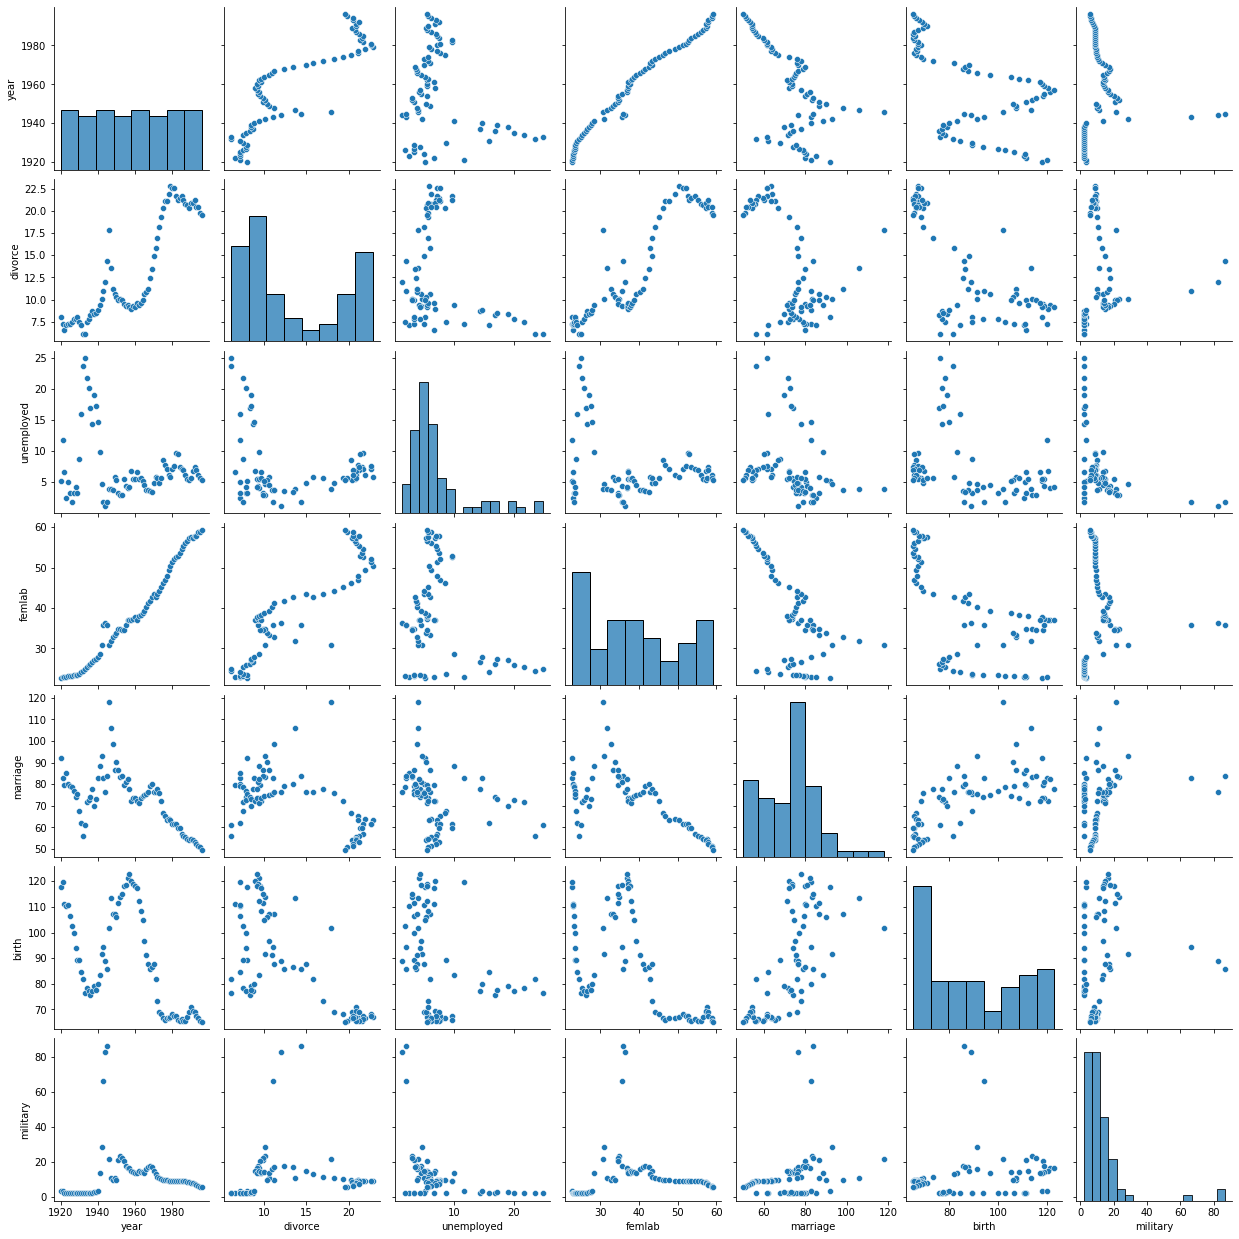

In [4]:
sns.pairplot(divusa)

In [5]:
import faraway.utils

lmod = smf.ols(
    "divorce ~ unemployed + femlab + marriage + birth + military",
    data=divusa
).fit()
lmod.sumary()

            coefs stderr tvalues pvalues
Intercept   2.488  3.394    0.73  0.4659
unemployed -0.111  0.056   -1.99  0.0505
femlab      0.384  0.031   12.54  0.0000
marriage    0.119  0.024    4.86  0.0000
birth      -0.130  0.016   -8.33  0.0000
military   -0.027  0.014   -1.88  0.0647

n=77 p=6 Residual SD=1.650 R-squared=0.92


In [6]:
%run utils.ipynb

(<Figure size 2000x700 with 2 Axes>,
 array([<AxesSubplot:xlabel='y.hat', ylabel='e.hat'>,
        <AxesSubplot:xlabel='y.hat', ylabel='sqrt(|e.hat|)'>], dtype=object))

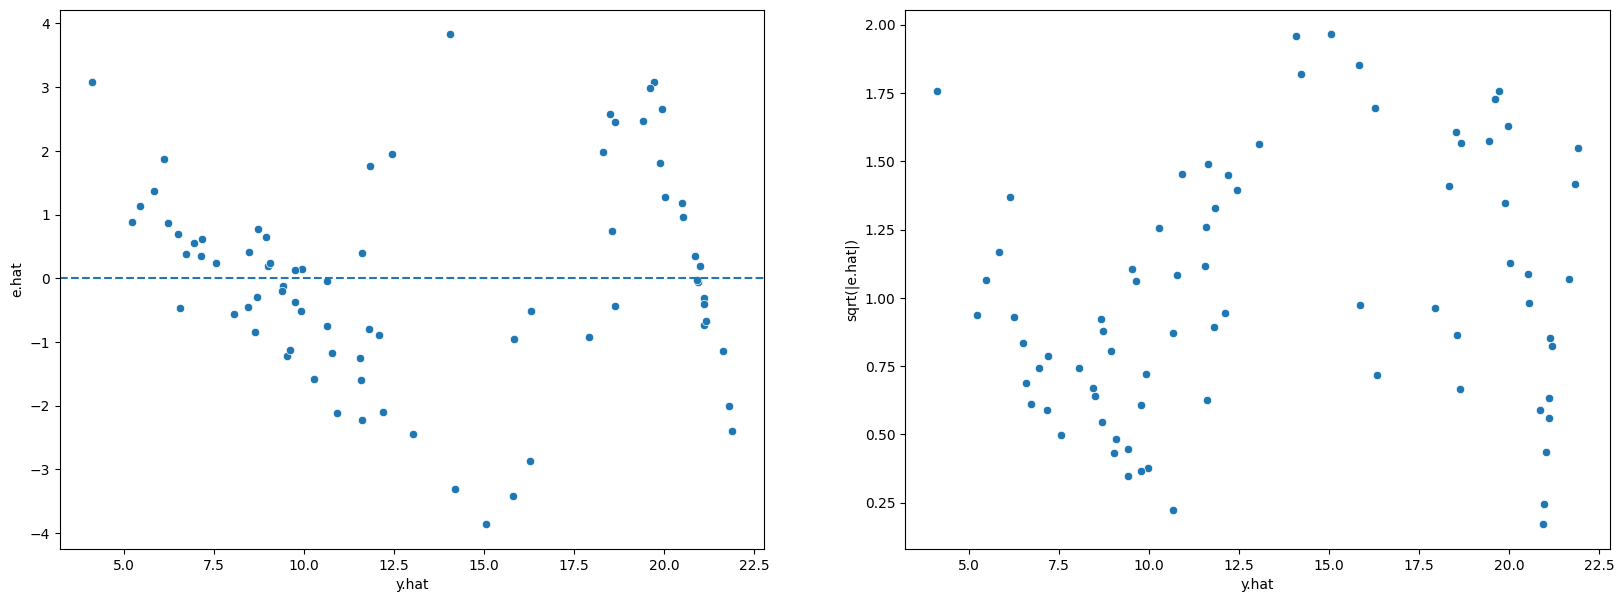

In [7]:
resid_yhat_plot(lmod)

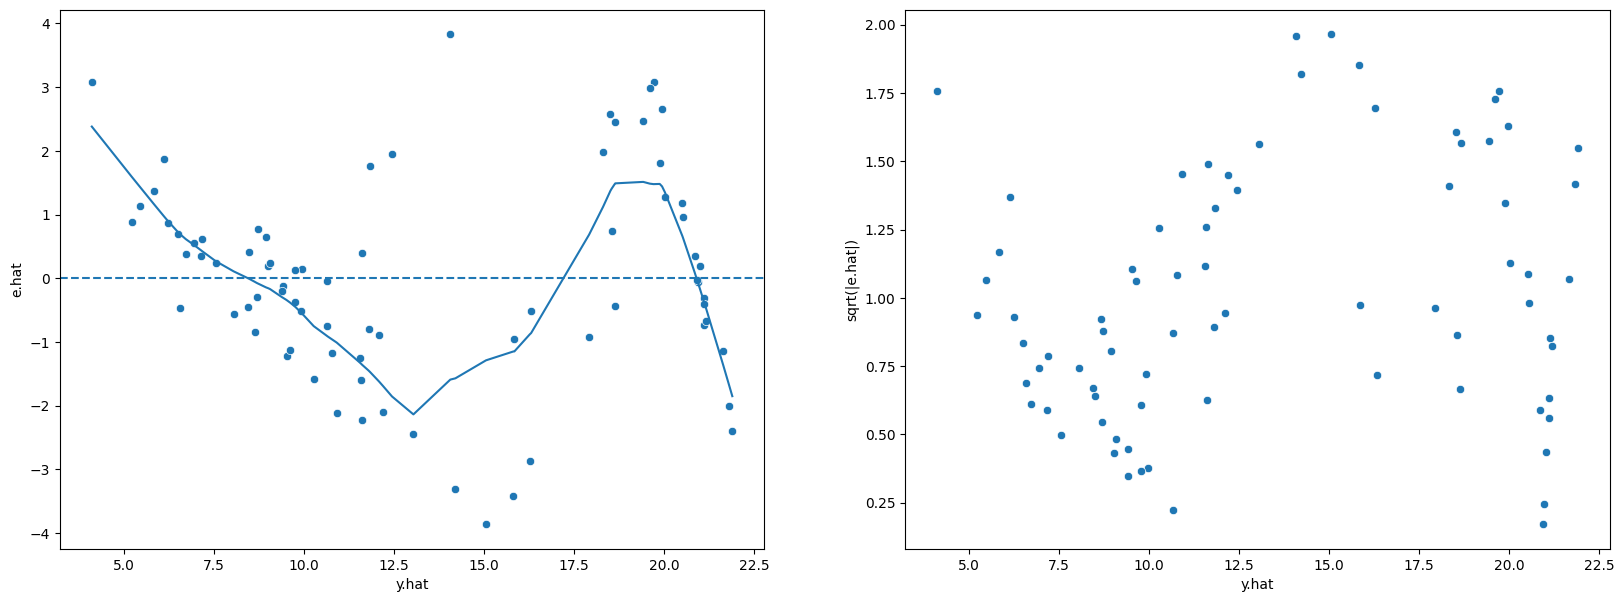

In [8]:
lowess = sm.nonparametric.lowess
f, ax = resid_yhat_plot(lmod)
smoothed = lowess(lmod.resid, lmod.fittedvalues, frac=1./3)
ax[0].plot(smoothed[:, 0], smoothed[:, 1])

In [9]:
sm.stats.stattools.durbin_watson(lmod.resid)

0.29988344695130037

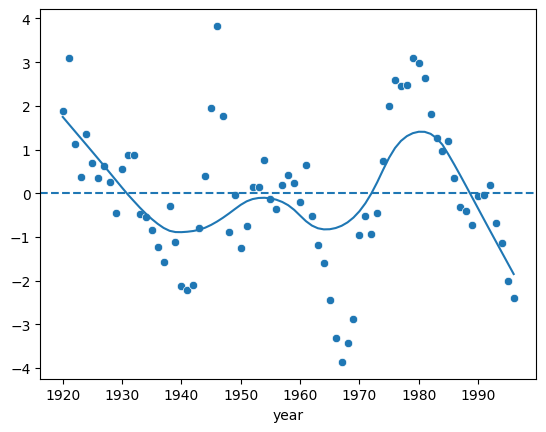

In [10]:
sns.scatterplot(
    x=divusa["year"],
    y=lmod.resid,
)
plt.axhline(0, ls='--')
smoothed = lowess(lmod.resid, divusa["year"], frac=1./3)
plt.plot(smoothed[:, 0], smoothed[:, 1])

### Condition number, VIF, collinearity

In [11]:
lmod.sumary()

            coefs stderr tvalues pvalues
Intercept   2.488  3.394    0.73  0.4659
unemployed -0.111  0.056   -1.99  0.0505
femlab      0.384  0.031   12.54  0.0000
marriage    0.119  0.024    4.86  0.0000
birth      -0.130  0.016   -8.33  0.0000
military   -0.027  0.014   -1.88  0.0647

n=77 p=6 Residual SD=1.650 R-squared=0.92


In [12]:
get_cond_nums(lmod)

array([2.22895689e+03, 2.51501325e+01, 1.37576470e+01, 8.53270253e+00,
       7.43276052e+00, 1.00000000e+00])

Values larger than 30 are considered to be troublesome. </br>
There seems to be an ill condition number </br>
Does this signify that there is **one** linear dependence among the predictors?

In [13]:
r_squareds = get_partial_rsq(lmod)
r_squareds

Intercept     0.996929
femlab        0.723243
marriage      0.650943
birth         0.613225
unemployed    0.556125
military      0.199741
dtype: float64

In [14]:
VIFs = 1 / (1 - r_squareds)
VIFs

Intercept     325.586716
femlab          3.613276
marriage        2.864864
birth           2.585485
unemployed      2.252888
military        1.249596
dtype: float64

The intercept value should always be ignored since it makes little sense for a VIF. </br>
Interpretation for *femlab*: had there not been collinearity in the dataset, we'd expect $sqrt(3.6)=1.8$ times less variability (standard deviation) in $\hat{\beta}_i$ </br>
We cannot apply this as a correction because
we did not actually observe orthogonal data, but it does give us a sense of the size of
the effect.

In [15]:
get_dsg_mtx(lmod).corr()

,unemployed,femlab,marriage,birth,military
unemployed,1.000000,-0.257462,-0.270763,-0.313889,-0.400293
femlab,-0.257462,1.000000,-0.648627,-0.604095,0.051263
marriage,-0.270763,-0.648627,1.000000,0.673727,0.258198
birth,-0.313889,-0.604095,0.673727,1.000000,0.140899
military,-0.400293,0.051263,0.258198,0.140899,1.000000


In [16]:
lmod_cut = smf.ols(
    "divorce ~ femlab + marriage + birth",
    data=divusa
).fit()
lmod_cut.sumary()

           coefs stderr tvalues pvalues
Intercept -1.545  2.212   -0.70  0.4871
femlab     0.413  0.023   18.17  0.0000
marriage   0.126  0.022    5.73  0.0000
birth     -0.116  0.014   -8.23  0.0000

n=77 p=4 Residual SD=1.695 R-squared=0.91


In [17]:
print(get_cond_nums(lmod_cut))
1 / (1-get_partial_rsq(lmod_cut))

[1.40464495e+03 1.36600682e+01 7.43206041e+00 1.00000000e+00]


Intercept    131.123023
marriage       2.201891
birth          2.008469
femlab         1.893390
dtype: float64

By removing insignificant variables, the condition numbers have decreased substantially, as well as the VIF's. </br> Conclusion: insign variables was a contributing factor to multicollinearity.

In [18]:
lmod_mil = smf.ols(
    "divorce ~ unemployed + femlab +  birth + marriage",
    data=divusa
).fit()


print(get_cond_nums(lmod_mil))
get_partial_rsq(lmod_mil)

[2.21650528e+03 2.27142450e+01 1.35910684e+01 7.43641703e+00
 1.00000000e+00]


Intercept     0.996927
femlab        0.722145
marriage      0.635530
birth         0.611145
unemployed    0.529131
dtype: float64

In [19]:
lmod3 = smf.ols(
    "divorce ~ unemployed + femlab +  birth",
    data=divusa
).fit()
lmod3.sumary()


print(get_cond_nums(lmod3))
get_partial_rsq(lmod3)

            coefs stderr tvalues pvalues
Intercept  13.449  2.777    4.84  0.0000
unemployed -0.196  0.056   -3.53  0.0007
femlab      0.300  0.029   10.49  0.0000
birth      -0.116  0.018   -6.63  0.0000

n=77 p=4 Residual SD=1.887 R-squared=0.89
[1.27044995e+03 1.76820622e+01 5.96892608e+00 1.00000000e+00]


Intercept     0.994002
birth         0.600930
femlab        0.586658
unemployed    0.413265
dtype: float64

In [20]:
lmod2 = smf.ols(
    "divorce ~ unemployed + marriage + birth + military",
    data=divusa
).fit()
lmod3 = smf.ols(
    "divorce ~ unemployed + femlab +  marriage + military",
    data=divusa
).fit()
lmod4 = smf.ols(
    "divorce ~ unemployed + femlab +  birth + military",
    data=divusa
).fit()
lmod5 = smf.ols(
    "divorce ~ unemployed + femlab +  birth + marriage",
    data=divusa
).fit()

lmod.sumary()
lmod2.sumary()
lmod3.sumary()
lmod4.sumary()
lmod5.sumary()

            coefs stderr tvalues pvalues
Intercept   2.488  3.394    0.73  0.4659
unemployed -0.111  0.056   -1.99  0.0505
femlab      0.384  0.031   12.54  0.0000
marriage    0.119  0.024    4.86  0.0000
birth      -0.130  0.016   -8.33  0.0000
military   -0.027  0.014   -1.88  0.0647

n=77 p=6 Residual SD=1.650 R-squared=0.92
            coefs stderr tvalues pvalues
Intercept  42.007  2.246   18.70  0.0000
unemployed -0.569  0.076   -7.53  0.0000
marriage   -0.057  0.036   -1.59  0.1173
birth      -0.229  0.024   -9.55  0.0000
military   -0.016  0.025   -0.61  0.5424

n=77 p=5 Residual SD=2.939 R-squared=0.75
             coefs stderr tvalues pvalues
Intercept  -13.175  3.947   -3.34  0.0013
unemployed   0.108  0.069    1.57  0.1212
femlab       0.513  0.037   13.91  0.0000
marriage     0.084  0.034    2.50  0.0149
military    -0.018  0.020   -0.91  0.3661

n=77 p=5 Residual SD=2.305 R-squared=0.84
            coefs stderr tvalues pvalues
Intercept  13.827  2.826    4.89  0.0000
unem

In [21]:
lmod4 = smf.ols(
    "divorce ~ np.log(femlab)",
    data=divusa
).fit()
lmod4.sumary()

print(get_cond_nums(lmod4))
1 / (1 -get_partial_rsq(lmod4))

                 coefs stderr tvalues pvalues
Intercept      -45.137  3.460  -13.05  0.0000
np.log(femlab)  16.198  0.956   16.94  0.0000

n=77 p=2 Residual SD=2.597 R-squared=0.79
[45.50939647  1.        ]


Intercept         136.631572
np.log(femlab)      1.000000
dtype: float64

Conclusion: multiocollinearity was present. We've removed it by looking at correlations between predictors and keeping only a subset of them. As a result, *femlab* was the only one whose keeping removed collinearity. As a result, we've lost 10% of our explanatory capabilities.

## Addressing correlation between the errors

In [22]:
lmod.sumary()
lmod.summary().tables[1]

            coefs stderr tvalues pvalues
Intercept   2.488  3.394    0.73  0.4659
unemployed -0.111  0.056   -1.99  0.0505
femlab      0.384  0.031   12.54  0.0000
marriage    0.119  0.024    4.86  0.0000
birth      -0.130  0.016   -8.33  0.0000
military   -0.027  0.014   -1.88  0.0647

n=77 p=6 Residual SD=1.650 R-squared=0.92


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.4878,3.394,0.733,0.466,-4.279,9.255
unemployed,-0.1113,0.056,-1.989,0.051,-0.223,0.000
femlab,0.3836,0.031,12.543,0.000,0.323,0.445
marriage,0.1187,0.024,4.861,0.000,0.070,0.167
birth,-0.1300,0.016,-8.333,0.000,-0.161,-0.099
military,-0.0267,0.014,-1.876,0.065,-0.055,0.002


In [23]:
lmod.resid.autocorr()

0.8469792313013874

We are fitting AR(1)

In [24]:
X = pd.DataFrame(lmod.model.wexog, columns=lmod.params.index)
y = lmod.model.wendog
gmod = sm.GLSAR(y, X, rho=1)
res = gmod.iterative_fit(maxiter=100)
gmod.rho.round(2)

array([0.99])

In [25]:
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,15.2089,13.029,1.167,0.247,-10.776,41.194
unemployed,0.0976,0.045,2.163,0.034,0.008,0.188
femlab,0.0620,0.152,0.407,0.685,-0.241,0.365
marriage,0.1587,0.023,7.038,0.000,0.114,0.204
birth,-0.0339,0.023,-1.483,0.142,-0.079,0.012
military,0.0381,0.017,2.252,0.027,0.004,0.072


### Model Selection

In [26]:
lmod.sumary()

            coefs stderr tvalues pvalues
Intercept   2.488  3.394    0.73  0.4659
unemployed -0.111  0.056   -1.99  0.0505
femlab      0.384  0.031   12.54  0.0000
marriage    0.119  0.024    4.86  0.0000
birth      -0.130  0.016   -8.33  0.0000
military   -0.027  0.014   -1.88  0.0647

n=77 p=6 Residual SD=1.650 R-squared=0.92


`unemployed` and `military` are insignificant

In [29]:
lmod_sign = smf.ols(
    "divorce ~ femlab + marriage + birth", 
    data=divusa
).fit()
lmod_sign.sumary()

           coefs stderr tvalues pvalues
Intercept -1.545  2.212   -0.70  0.4871
femlab     0.413  0.023   18.17  0.0000
marriage   0.126  0.022    5.73  0.0000
birth     -0.116  0.014   -8.23  0.0000

n=77 p=4 Residual SD=1.695 R-squared=0.91


In [31]:
lmod.compare_f_test(lmod_sign)

(3.0184805334715183, 0.05518891041208877, 2.0)

We fail to reject $$H_0: \beta_{unemployed}=\beta_{military}=0 $$
The variation between two groups is insignificant

In [33]:
sm.stats.anova_lm(lmod_sign, lmod)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,73.0,209.840963,0.0,NaN,NaN,NaN
1,71.0,193.396886,2.0,16.444077,3.018481,0.055189


In [45]:
import itertools
X = pd.DataFrame(lmod.model.exog, columns=lmod.params.index)
y = lmod.model.endog

pcols = list(X.columns.drop("Intercept"))

res = pd.DataFrame(columns=["rss", "se", "aic", "r2adj"])

for k in [4,5]:
    for variables in itertools.combinations(pcols, k):
        variables = list(variables)
        variables.append("Intercept")
        predictors = X.loc[:, variables]

        lmodi = sm.OLS(y, predictors).fit()
        resi = pd.DataFrame({
                "rss": lmodi.ssr, 
                "se": np.sqrt(lmodi.ssr/lmod.df_resid),
                "aic": lmodi.aic,
                "r2adj": lmodi.rsquared_adj,
            }, 
            index=[str(variables)]
        )
        res = pd.concat([res, resi])
res

,rss,se,aic,r2adj
"['unemployed', 'femlab', 'marriage', 'birth', 'Intercept']",202.987739,1.690853,303.155726,0.912277
"['unemployed', 'femlab', 'marriage', 'military', 'Intercept']",382.558896,2.321240,351.953478,0.834674
"['unemployed', 'femlab', 'birth', 'military', 'Intercept']",257.756859,1.905355,321.548805,0.888608
"['unemployed', 'marriage', 'birth', 'military', 'Intercept']",621.938643,2.959679,389.372308,0.731225
"['femlab', 'marriage', 'birth', 'military', 'Intercept']",204.176423,1.695796,303.605318,0.911764
"['unemployed', 'femlab', 'marriage', 'birth', 'military', 'Intercept']",193.396886,1.650424,301.428842,0.915245


Full model is better in terms of $AIC$ and $R^2_{adj}$
Conlcusion: fail to reject difference in variation between two models (F-test) does not imply that the model performs comparably in term of AIC and R2. In other words, we cannot restrict our attention ONLY to models with ..

In [34]:
divusa.head()

,year,divorce,unemployed,femlab,marriage,birth,military
0,1920,8.0,5.2,22.70,92.0,117.9,3.2247
1,1921,7.2,11.7,22.79,83.0,119.8,3.5614
2,1922,6.6,6.7,22.88,79.7,111.2,2.4553
3,1923,7.1,2.4,22.97,85.2,110.5,2.2065
4,1924,7.2,5.0,23.06,80.3,110.9,2.2889


In [35]:
lmod.sumary()

            coefs stderr tvalues pvalues
Intercept   2.488  3.394    0.73  0.4659
unemployed -0.111  0.056   -1.99  0.0505
femlab      0.384  0.031   12.54  0.0000
marriage    0.119  0.024    4.86  0.0000
birth      -0.130  0.016   -8.33  0.0000
military   -0.027  0.014   -1.88  0.0647

n=77 p=6 Residual SD=1.650 R-squared=0.92
